### Setup and Dependency Installation

#### 📦 Import Library Umum
Import library dasar yang digunakan untuk manipulasi data, visualisasi, logging, dan utilitas lainnya.


In [1]:
import os
import re
import time
import json
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from dotenv import load_dotenv
from IPython.display import display, Markdown, HTML
from wordcloud import WordCloud

#### 🤖 Import TensorFlow dan Keras
Library ini digunakan untuk membangun dan melatih model deep learning seperti LSTM dan CNN.


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten

#### 📚 Import NLTK untuk NLP
Library Natural Language Toolkit (NLTK) digunakan untuk tokenisasi dan menghapus stopwords dari teks.


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#### 🧠 Import Scikit-learn
Digunakan untuk preprocessing teks, evaluasi model, dan teknik reduksi dimensi seperti PCA/SVD.


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD

#### 🤗 Import Transformers dari HuggingFace
Model transformer seperti BERT, RoBERTa, dan XLNet digunakan untuk analisis sentimen berbasis deep learning modern.

In [5]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
    BertTokenizer,
    BertForSequenceClassification,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    XLNetTokenizer,
    XLNetForSequenceClassification,
)
from huggingface_hub import InferenceClient

#### 🌐 Import Google API
Untuk mengambil data dari YouTube dan mengakses model generatif Google (Gemini).

In [6]:
from googleapiclient.discovery import build
import google.generativeai as genai

#### ⚙️ Nonaktifkan Warning & Atur Tampilan
Untuk menghindari cluttering pada output dan mempercantik visualisasi.


In [7]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

pd.set_option("display.max_colwidth", 100)
plt.style.use("seaborn-v0_8-whitegrid")
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

#### 📥 Download Resource NLTK
Mengunduh resource NLTK yang dibutuhkan untuk tokenisasi dan stopword bahasa Indonesia.


In [8]:
print("Downloading NLTK resources...")
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
stop_words = set(stopwords.words("indonesian"))

print("✅ All required libraries imported successfully")
print("✅ NLTK resources downloaded successfully")

✅ All required libraries imported successfully
✅ NLTK resources downloaded successfully


### Environment Setup and Configuration

#### 📋 Logging Initialization
Mengatur sistem logging untuk mencatat aktivitas selama eksekusi pipeline, termasuk format waktu dan level informasi.


In [9]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

#### 🔐 Setup Gemini API (Google Generative AI)
Mengambil API Key Gemini dari environment variable atau meminta input jika tidak tersedia. Kemudian inisialisasi model `gemini-2.0-flash`.

In [10]:
GEMINI_API_KEYS = [
    v for k, v in os.environ.items()
    if k.startswith("GEMINI_API_KEY_") and v
]
if not GEMINI_API_KEYS:
    GEMINI_API_KEYS = [
        input(f"Enter Gemini API Key #{i+1}: ")
        for i in range(5)
    ]

# Konfigurasi model Gemini
models = [genai.GenerativeModel('gemini-2.0-flash') for _ in GEMINI_API_KEYS]
for api_key, model in zip(GEMINI_API_KEYS, models):
    genai.configure(api_key=api_key)

#### 📺 Setup YouTube API
Mengambil API Key YouTube dan ID video dari environment variable atau input user.


In [11]:
YOUTUBE_API_KEY = os.getenv('YOUTUBE_API_KEY') or input("Enter your YouTube API Key: ")
VIDEO_ID        = os.getenv('VIDEO_ID')        or input("Enter the YouTube Video ID: ")

#### 🤗 Setup Hugging Face API
Mengambil API Key Hugging Face dari environment variable atau input manual, lalu inisialisasi client.

In [12]:
HF_API_KEYS = [
    v for k, v in os.environ.items()
    if k.startswith("HF_API_KEY_") and v
]
if not HF_API_KEYS:
    HF_API_KEYS = [
        input(f"Enter Hugging Face API Key #{i+1}: ")
        for i in range(3)
    ]

hf_clients = [InferenceClient(token=api_key) for api_key in HF_API_KEYS]

#### 🗂️ Setup Struktur Direktori Output
Membuat struktur folder untuk menyimpan hasil setiap tahap analisis seperti pengumpulan data, preprocessing, analisis, dll.


In [13]:
BASE_OUTPUT = os.getenv('OUTPUT_DIR', './output')

STAGES = {
    '01_comments_collection':     None,
    '02_preprocessing':           None,
    '03_eda':                     None,
    '04_clustering':              None,
    '05_sentiment':               None,
    '06_transformer_comparison':  None,
    '07_advanced_insights':       None
}

subdirs = {}
for stage in STAGES:
    stage_path = os.path.join(BASE_OUTPUT, stage)
    os.makedirs(stage_path, exist_ok=True)
    subdirs[stage] = {}
    for sub in ('analisis', 'visualisasi'):
        path = os.path.join(stage_path, sub)
        os.makedirs(path, exist_ok=True)
        subdirs[stage][sub] = path

#### ✅ Logging Struktur Folder Output
Menampilkan struktur folder yang telah dibuat ke dalam log agar mudah dilacak dan dipastikan.

In [14]:
logger.info("Directory structure initialized under %s", BASE_OUTPUT)
for stage, subs in subdirs.items():
    logger.info("Stage %-25s:", stage)
    for name, path in subs.items():
        logger.info("  - %-12s -> %s", name, path)

2025-05-08 08:21:20 INFO Directory structure initialized under ./output
2025-05-08 08:21:20 INFO Stage 01_comments_collection   :
2025-05-08 08:21:20 INFO   - analisis     -> ./output/01_comments_collection/analisis
2025-05-08 08:21:20 INFO   - visualisasi  -> ./output/01_comments_collection/visualisasi
2025-05-08 08:21:20 INFO Stage 02_preprocessing         :
2025-05-08 08:21:20 INFO   - analisis     -> ./output/02_preprocessing/analisis
2025-05-08 08:21:20 INFO   - visualisasi  -> ./output/02_preprocessing/visualisasi
2025-05-08 08:21:20 INFO Stage 03_eda                   :
2025-05-08 08:21:20 INFO   - analisis     -> ./output/03_eda/analisis
2025-05-08 08:21:20 INFO   - visualisasi  -> ./output/03_eda/visualisasi
2025-05-08 08:21:20 INFO Stage 04_clustering            :
2025-05-08 08:21:20 INFO   - analisis     -> ./output/04_clustering/analisis
2025-05-08 08:21:20 INFO   - visualisasi  -> ./output/04_clustering/visualisasi
2025-05-08 08:21:20 INFO Stage 05_sentiment             :


### YouTube Comments Collection

#### 📁 Inisialisasi Path Direktori
Menentukan lokasi folder untuk menyimpan data komentar mentah dan hasil visualisasi awal pada tahap `01_comments_collection`.


In [15]:
COMMENTS_DIR = subdirs['01_comments_collection']['analisis']
VISUALS_DIR  = subdirs['01_comments_collection']['visualisasi']

#### 📥 Fungsi Pengambilan Komentar YouTube
Fungsi `get_youtube_comments` akan mengambil komentar dari sebuah video YouTube menggunakan YouTube Data API.
Komentar yang diambil mencakup nama pengguna, isi komentar, waktu publikasi, dan jumlah like.


In [16]:
def get_youtube_comments(video_id: str, api_key: str) -> pd.DataFrame:
    client = build("youtube", "v3", developerKey=api_key)
    comments = []
    request = client.commentThreads().list(
        part="snippet",
        videoId=video_id,
        maxResults=100,
        textFormat="plainText"
    )
    with tqdm(desc="Fetching comments", unit="comment") as pbar:
        while request:
            response = request.execute()
            for item in response.get("items", []):
                s = item["snippet"]["topLevelComment"]["snippet"]
                comments.append({
                    "comment_id":   item["id"],
                    "author":       s.get("authorDisplayName"),
                    "text":         s.get("textDisplay"),
                    "published_at": s.get("publishedAt"),
                    "like_count":   s.get("likeCount", 0)
                })
                pbar.update(1)
            request = client.commentThreads().list_next(request, response)

    df = pd.DataFrame(comments)
    logger.info("Retrieved %d comments", len(df))
    return df

#### ▶️ Eksekusi Pengambilan Komentar
Menjalankan fungsi `get_youtube_comments` untuk mengambil komentar dari video sesuai ID yang telah ditentukan.


In [17]:
logger.info("Starting YouTube comment collection for video %s", VIDEO_ID)
df_comments = get_youtube_comments(VIDEO_ID, YOUTUBE_API_KEY)

2025-05-08 08:21:20 INFO Starting YouTube comment collection for video -WLpXmnBmxo
2025-05-08 08:21:20 INFO file_cache is only supported with oauth2client<4.0.0
Fetching comments: 10405comment [00:14, 710.86comment/s]
2025-05-08 08:21:35 INFO Retrieved 10405 comments


#### 💾 Menyimpan Komentar ke CSV
Komentar yang telah dikumpulkan disimpan dalam file CSV agar bisa digunakan untuk tahap selanjutnya seperti preprocessing dan analisis.


In [18]:
csv_path = os.path.join(COMMENTS_DIR, "comments_raw.csv")
df_comments.to_csv(csv_path, index=False)
logger.info("Saved raw comments to %s", csv_path)

2025-05-08 08:21:35 INFO Saved raw comments to ./output/01_comments_collection/analisis/comments_raw.csv


#### 🖼️ Menampilkan Sampel Komentar
Melihat beberapa komentar pertama yang berhasil dikumpulkan sebagai verifikasi awal terhadap data yang diambil.


In [19]:
display(Markdown("#### Sample of Collected Comments"))
display(df_comments.head())

#### Sample of Collected Comments

,comment_id,author,text,published_at,like_count
0,UgwBpiBAPmLFVkSXdDl4AaABAg,@tonisuhartono4766,🇮🇩\n💙💝✌🏻\n👍👍👍👍👍👍👍👍👍👍👍👍👍👍,2025-05-08T01:19:06Z,0
1,UgxGj_4fD-U2hgHAvlB4AaABAg,@NjiAhmad-x8m,Ngelihat komen masih banyak yg sadar ternyata,2025-05-07T20:50:57Z,0
2,UgyagarwqGdjRiuahbF4AaABAg,@nikozio4981,"Krain maung, Ternyata meow..\nJawaban ga ada yg di jwb",2025-05-07T15:59:39Z,0
3,Ugz8Chl5ZOmr-hBmmVV4AaABAg,@Beeyourrselff,"Pak prabowo jangan ketularan wakilnya dong, 3 jam ngulang2 bener2 ujian buat saya.",2025-05-07T14:00:17Z,0
4,UgxjYX04V6EjtioNoW54AaABAg,@fahreeladjie2738,"Dari pandangan saya dan pendapat pribadi saya presiden ini dia gak liat fakta di lapangan , beli...",2025-05-07T10:56:28Z,0


### Data Preprocessing and Cleaning

#### 📁 Inisialisasi Direktori Preprocessing
Menentukan direktori untuk menyimpan hasil preprocessing dan visualisasi tahap kedua (`02_preprocessing`).


In [20]:
PREPROCESS_DIR = subdirs['02_preprocessing']['analisis']
VISUAL_DIR     = subdirs['02_preprocessing']['visualisasi']
os.makedirs(PREPROCESS_DIR, exist_ok=True)
os.makedirs(VISUAL_DIR, exist_ok=True)

#### 🧬 Duplikasi Data & Cek Missing Values
Menduplikasi dataframe asli untuk preprocessing dan menampilkan jumlah nilai kosong (missing values) pada setiap kolom.

In [21]:
df = df_comments.copy()

missing = df.isnull().sum()
percent = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'missing_values': missing, 'percentage': percent})
display(missing_df)

,missing_values,percentage
comment_id,0,0.0
author,0,0.0
text,0,0.0
published_at,0,0.0
like_count,0,0.0


#### 🧹 Hapus Komentar Kosong & Siapkan Stopwords
Menghapus komentar yang tidak memiliki teks dan memuat daftar stopwords Bahasa Indonesia dari NLTK.

In [22]:
df = df.dropna(subset=['text'])
stop_words = set(stopwords.words('indonesian'))

#### 🔧 Fungsi `clean_text`
Fungsi ini mengubah teks ke huruf kecil, menghapus tag HTML, link, tanda baca, angka, dan kata-kata tidak penting (stopwords).


In [23]:
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'<.*?>|http\S+|www\.\S+|https\S+|[^\w\s]|\d+', ' ', text)
    tokens = word_tokenize(text)
    return ' '.join(w for w in tokens if w not in stop_words and len(w) > 2)

#### 🧼 Terapkan `clean_text` ke Semua Komentar
Menerapkan fungsi pembersihan ke setiap komentar dan menghapus hasil yang kosong setelah dibersihkan.


In [24]:
df['cleaned_text'] = df['text'].apply(clean_text)
df = df[df['cleaned_text'].str.strip() != '']

#### 📊 Statistik Komentar
Menambahkan kolom panjang komentar sebelum dan sesudah dibersihkan, serta menghitung jumlah kata.
Ditampilkan statistik deskriptif dari hasil ini.


In [25]:
df['original_length'] = df['text'].str.len()
df['cleaned_length']  = df['cleaned_text'].str.len()
df['word_count']      = df['cleaned_text'].str.split().str.len()

stats = df[['original_length', 'cleaned_length', 'word_count']].describe()
display(stats)

,original_length,cleaned_length,word_count
count,10148.000000,10148.000000,10148.000000
mean,117.326862,70.881356,10.016456
std,178.704247,103.506321,13.664821
min,3.000000,3.000000,1.000000
25%,34.000000,21.000000,3.000000
50%,67.000000,41.000000,6.000000
75%,134.000000,82.000000,12.000000
max,5856.000000,2751.000000,339.000000


#### 💾 Simpan Hasil Preprocessing
Data komentar yang telah dibersihkan disimpan ke file CSV agar bisa digunakan di tahap berikutnya.


In [26]:
preprocessed_path = os.path.join(PREPROCESS_DIR, 'preprocessed_comments.csv')
df.to_csv(preprocessed_path, index=False)

#### 👀 Sampel Komentar Setelah Preprocessing
Menampilkan beberapa contoh komentar sebelum dan sesudah dibersihkan, beserta jumlah kata hasil pembersihan.

In [27]:
display(df[['text', 'cleaned_text', 'word_count']].head())

,text,cleaned_text,word_count
1,Ngelihat komen masih banyak yg sadar ternyata,ngelihat komen sadar,3
2,"Krain maung, Ternyata meow..\nJawaban ga ada yg di jwb",krain maung meow jwb,4
3,"Pak prabowo jangan ketularan wakilnya dong, 3 jam ngulang2 bener2 ujian buat saya.",prabowo ketularan wakilnya jam ngulang bener ujian,7
4,"Dari pandangan saya dan pendapat pribadi saya presiden ini dia gak liat fakta di lapangan , beli...",pandangan pendapat pribadi presiden gak liat fakta lapangan beliau keknya liat nya data dikasih ...,28
5,"Baru aja ngeklik, udh ngantuk aja",aja ngeklik udh ngantuk aja,5


### Exploratory Data Analysis (EDA)

#### 📁 Inisialisasi Direktori EDA dan Load Data
Membuat direktori untuk hasil analisis dan visualisasi EDA, lalu memuat data komentar yang sudah dipreproses.

In [28]:
EDA_ANALYSIS_DIR = subdirs['03_eda']['analisis']
EDA_VISUAL_DIR   = subdirs['03_eda']['visualisasi']
os.makedirs(EDA_ANALYSIS_DIR, exist_ok=True)
os.makedirs(EDA_VISUAL_DIR, exist_ok=True)

PREPROCESS_DIR   = subdirs['02_preprocessing']['analisis']
preprocessed_path = os.path.join(PREPROCESS_DIR, 'preprocessed_comments.csv')
df = pd.read_csv(preprocessed_path, parse_dates=['published_at'])

#### 🧪 Rekayasa Fitur Tambahan
Menambahkan fitur seperti jumlah kata, panjang teks, dan waktu publikasi (tanggal dan jam).

In [29]:
df['word_count']       = df['cleaned_text'].str.split().str.len()
df['cleaned_length']   = df['cleaned_text'].str.len()
df['original_length']  = df['text'].str.len()
df['publication_date'] = df['published_at'].dt.normalize()
df['publication_hour'] = df['published_at'].dt.hour

#### 📏 Distribusi Panjang Komentar
Visualisasi distribusi dan boxplot untuk jumlah kata dan karakter dalam komentar.

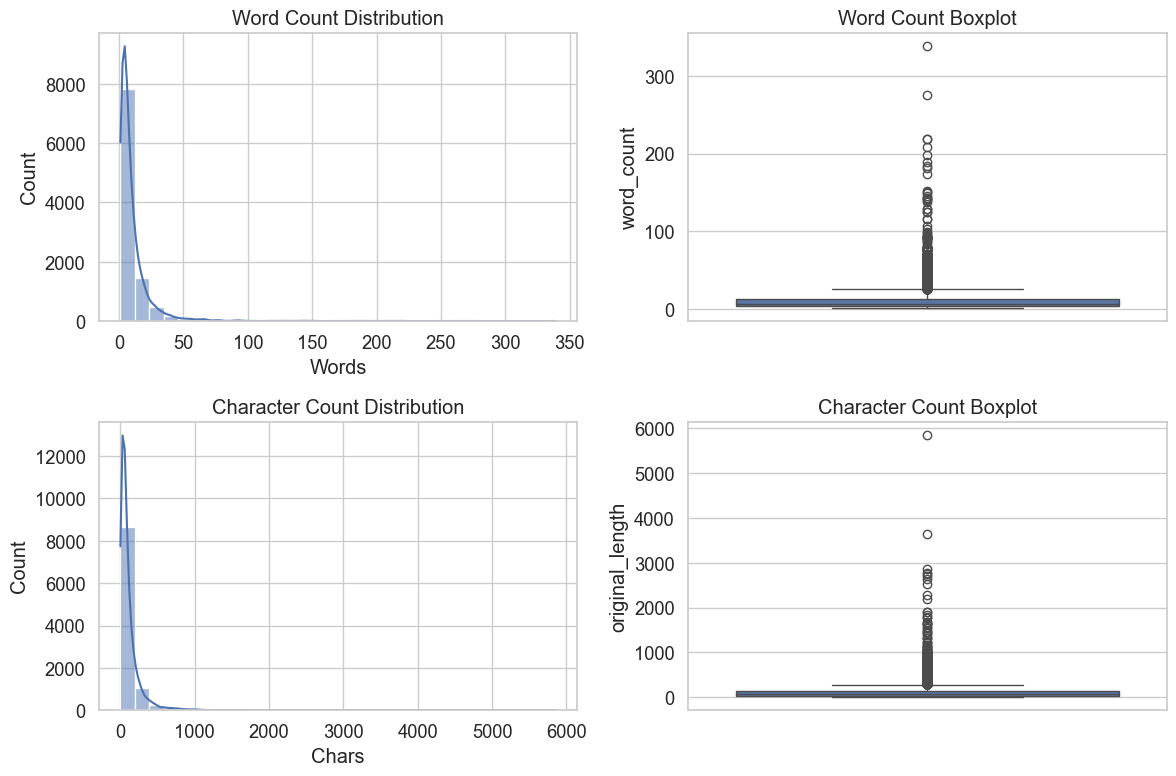

In [30]:
fig1, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df['word_count'], kde=True, bins=30, ax=axes[0,0]).set(title='Word Count Distribution', xlabel='Words')
sns.boxplot(y=df['word_count'], ax=axes[0,1]).set(title='Word Count Boxplot')
sns.histplot(df['original_length'], kde=True, bins=30, ax=axes[1,0]).set(title='Character Count Distribution', xlabel='Chars')
sns.boxplot(y=df['original_length'], ax=axes[1,1]).set(title='Character Count Boxplot')
fig1.tight_layout()
fig1.savefig(os.path.join(EDA_VISUAL_DIR, 'length_distribution.png'))
plt.show()

#### 🚨 Deteksi Outlier Jumlah Kata
Menghitung dan menyimpan komentar yang berada di luar rentang normal berdasarkan distribusi jumlah kata.

In [31]:
Q1, Q3 = df['word_count'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lb, ub = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
outliers = df[(df['word_count'] < lb) | (df['word_count'] > ub)]
outliers.to_csv(os.path.join(EDA_ANALYSIS_DIR, 'word_count_outliers.csv'), index=False)
display(outliers[['text', 'word_count']].sort_values('word_count', ascending=False).head())

,text,word_count
7983,"Saya nonton full 3 jam dan saya salut dengan Pak Presiden yang mau membuat acara seperti ini, ma...",339
7051,Ini adalah ringkasan yang dibuat oleh AI. Mungkin ada ketidakakuratan.\n\nDurasi 00:00:00 - 01:0...,276
8855,Analisis Kritis terhadap Gagasan Politik-Ekonomi Presiden Prabowo dalam wawancara ini: \n\n1. Pr...,219
7007,"Rekomendasi nonton minimal 1,5x\r\n\r\n28:40 P1 Alfito Deannova (DetikCom)\r\n\r\n29:17 Mulai Ja...",219
8956,"pertanyaan 150 hari pencapaian:\nawal-awal tidak dicatat.\n\n9:07: ""saya laksanakan keyakinan sa...",208


#### 🕒 Pola Waktu Publikasi Komentar
Visualisasi jumlah komentar berdasarkan tanggal dan jam publikasi.


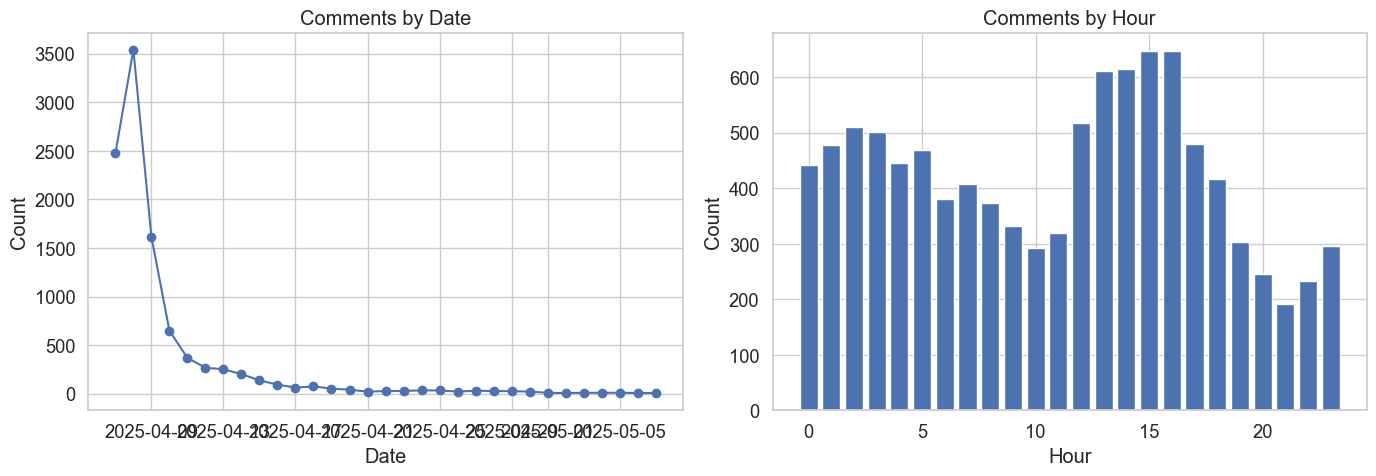

In [32]:
date_counts = df.groupby('publication_date').size()
hour_counts = df['publication_hour'].value_counts().sort_index()

fig2, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(date_counts.index, date_counts.values, marker='o')
axes[0].set(title='Comments by Date', xlabel='Date', ylabel='Count')
axes[1].bar(hour_counts.index, hour_counts.values)
axes[1].set(title='Comments by Hour', xlabel='Hour', ylabel='Count')
fig2.tight_layout()
fig2.savefig(os.path.join(EDA_VISUAL_DIR, 'publication_time.png'))
plt.show()

#### 👍 Distribusi Jumlah Like
Visualisasi distribusi dan boxplot untuk jumlah like pada komentar.

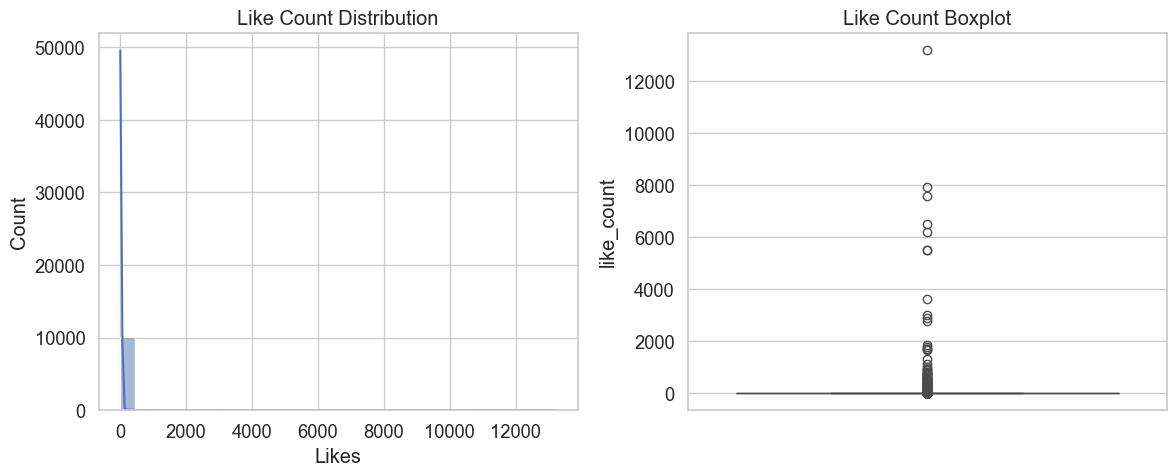

In [33]:
fig3, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['like_count'], kde=True, bins=30, ax=axes[0]).set(title='Like Count Distribution', xlabel='Likes')
sns.boxplot(y=df['like_count'], ax=axes[1]).set(title='Like Count Boxplot')
fig3.tight_layout()
fig3.savefig(os.path.join(EDA_VISUAL_DIR, 'like_count_analysis.png'))
plt.show()

#### 🌟 Top Komentar dengan Like Tertinggi
Menampilkan 5 komentar yang mendapat like terbanyak.

In [35]:
top_liked = df.nlargest(5, 'like_count')
display(top_liked[['author', 'text', 'like_count']])

,author,text,like_count
4928,@033_MUHAMMADARBYRAMADHAN,"Terima kasih, pak. Hasil diskusi ini berhasil menjawab kekhawatiran saya bahwa kita harus lebih ...",13216
7741,@dhimasputratama631,"Video ini sangat solutif, bagi saya yang memiliki gangguan pola tidur. Saya tadi malam susah tid...",7920
9144,@sofyanudin,1) *GANTI MENTERI2 KORUP*\n2) *SAHKAN UU PERAMPASAN ASSET KORUPTOR*\n3) *BATALKAN UU PERAMPASAN ...,7596
6944,@Xui_Ana,"Alhamdulillah video yg sangat bermanfaat, setiap beberapa detik saya mendengarkan saya selalu is...",6514
6405,@avichabastiansr5623,"Next, wakil presiden Gibran Rakabuming menjawab. Pliss harus sering ada acara² kayak giniii, bia...",6208


#### 🔠 Frekuensi Kata Terbanyak
Menampilkan 20 kata yang paling sering muncul dalam komentar yang sudah dibersihkan.


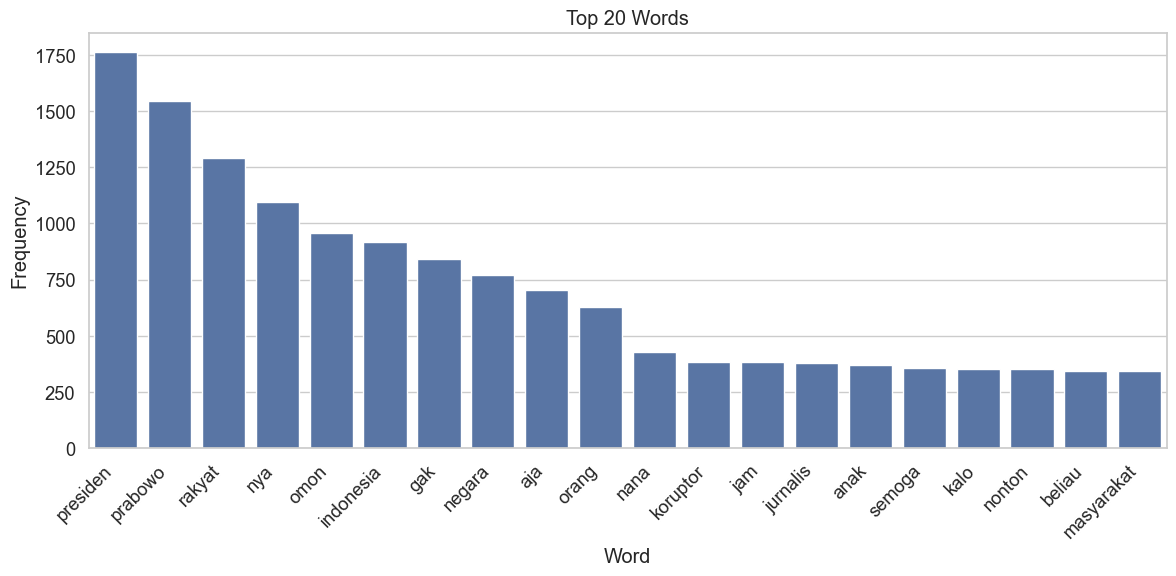

In [36]:
words, counts = zip(*Counter(" ".join(df['cleaned_text']).split()).most_common(20))
fig4 = plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts), ax=fig4.add_subplot(111)).set(title='Top 20 Words', xlabel='Word', ylabel='Frequency')
plt.xticks(rotation=45, ha='right')
fig4.tight_layout()
fig4.savefig(os.path.join(EDA_VISUAL_DIR, 'top_words.png'))
plt.show()

#### ☁️ Word Cloud Komentar
Visualisasi Word Cloud untuk komentar yang sudah dibersihkan dari stopwords.


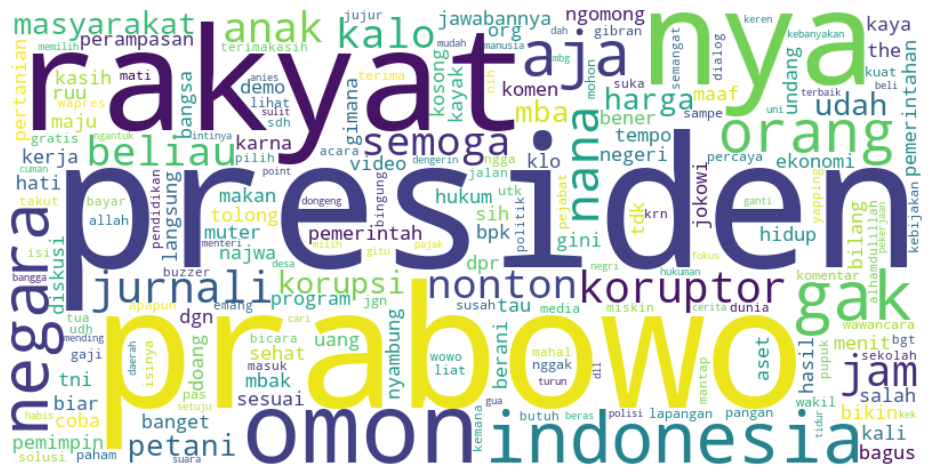

In [37]:
wc = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, collocations=False).generate(" ".join(df['cleaned_text']))
fig5 = plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
fig5.tight_layout()
fig5.savefig(os.path.join(EDA_VISUAL_DIR, 'wordcloud.png'))
plt.show()

#### 📈 Korelasi Antar Fitur
Menampilkan matriks korelasi antara panjang teks, jumlah kata, dan jumlah like.

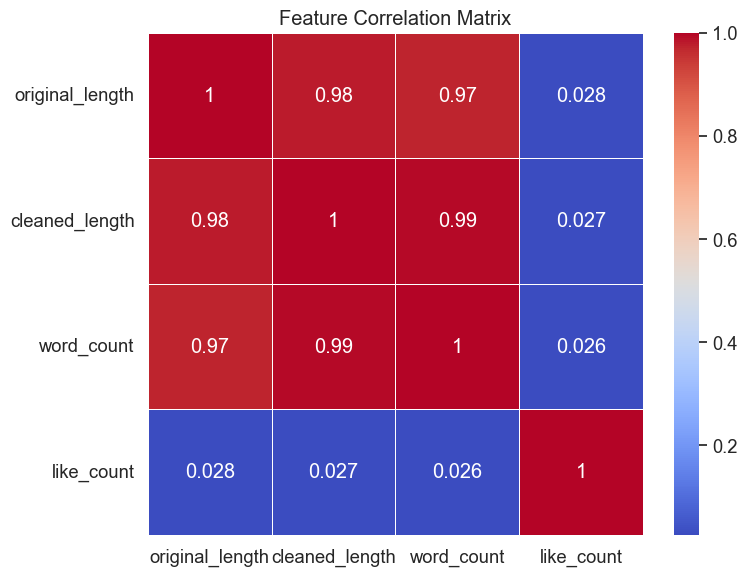

In [38]:
numeric = df[['original_length', 'cleaned_length', 'word_count', 'like_count']]
corr = numeric.corr()
fig6 = plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5).set(title='Feature Correlation Matrix')
fig6.tight_layout()
fig6.savefig(os.path.join(EDA_VISUAL_DIR, 'correlation_matrix.png'))
plt.show()

#### 📊 Ringkasan EDA
Menampilkan metrik-metrik penting hasil analisis eksplorasi data komentar.


In [39]:
summary = {
    'Total Comments':      len(df),
    'Average Word Count':  df['word_count'].mean(),
    'Median Word Count':   df['word_count'].median(),
    'Max Word Count':      df['word_count'].max(),
    'Average Likes':       df['like_count'].mean(),
    'Total Likes':         df['like_count'].sum(),
    'Outlier Count':       len(outliers),
    'Peak Date':           date_counts.idxmax(),
    'Peak Hour':           hour_counts.idxmax()
}

for k, v in summary.items():
    print(f"{k}: {v}")

Total Comments: 10148
Average Word Count: 10.01645644461963
Median Word Count: 6.0
Max Word Count: 339
Average Likes: 11.695999211667324
Total Likes: 118691
Outlier Count: 737
Peak Date: 2025-04-08 00:00:00+00:00
Peak Hour: 16
